**TODO** select non-overlapping windows only (to avoid the non-independence between sites)

The basic idea is to find out which categories of genomic regions (exons, promoters, enhancers, etc) contribute the most to the Nea. ancestry observed in present day Europeans. For example: have coding regions or enhancers been the main drivers of selection against Nea. introgression?

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html
* biotypes FAQ: http://www.ensembl.org/Help/Glossary

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

In [1]:
suppressWarnings({
    library(biomaRt)
    library(rtracklayer)
    library(BSgenome.Hsapiens.UCSC.hg19)
})

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, cbind, colnames, do.call, duplicated, eval, evalq,
    get, grep, grepl, intersect, is.unsorted, lapply, lengths, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int, rank,
    rbind, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors

Attaching package: ‘S4V

In [2]:
suppressWarnings({
    library(tidyverse)
    library(stringr)
    library(magrittr)
})

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
Position(): ggplot2, BiocGenerics, base
collapse(): dplyr, Biostrings, IRanges
combine():  dplyr, BiocGenerics
compact():  purrr, XVector
desc():     dplyr, IRanges
expand():   tidyr, S4Vectors
filter():   dplyr, stats
first():    dplyr, S4Vectors
lag():      dplyr, stats
reduce():   purrr, GenomicRanges, IRanges
rename():   dplyr, S4Vectors
select():   dplyr, biomaRt
simplify(): purrr, IRanges
slice():    dplyr, XVector, IRanges

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



## Get coordinates of admixture array sites

In [3]:
source("../R/utils.R")

In [4]:
# load the sample information
sgdp <- load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
    filter(! Region %in% c("Africa", "Oceania")) %>%
    dplyr::select(-Country, pop=Region) %>%
    mutate(age=0) %>%
    group_by(name, age, pop) %>%
    summarise(Latitude=mean(Latitude), Longitude=mean(Longitude)) %>%
    ungroup
emhs <- read_delim("../clean_data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(name=str_replace(name, "-", "_"), pop="EMH", Latitude=NA, Longitude=NA) %>%
    filter(name != "Oase1")
samples <- bind_rows(emhs, sgdp)

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  name = col_character(),
  age = col_integer()
)


In [5]:
genotypes <-
    load_dataset("../clean_data/ice_age.tsv",
                 "../clean_data/sgdp.tsv",
                 "../clean_data/archaics.tsv",
                 random_sample=FALSE) %>%
    select(c("chrom", "pos", sgdp$name)) %>%
    mutate(start=pos, end=pos) %>%
    select(-pos) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

seqlevelsStyle(genotypes) <- "UCSC"
seqinfo(genotypes) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),
  Vindija = col_integer(),
  Denisovan = col_integer()
)
Joining, by = c("chrom", "pos", "ref", "alt")
Joining, by = c("chrom", "pos", "ref", "alt")


In [6]:
sites <- granges(genotypes)

In [7]:
sites

GRanges object with 484016 ranges and 0 metadata columns:
           seqnames               ranges strand
              <Rle>            <IRanges>  <Rle>
       [1]     chr1     [847983, 847983]      *
       [2]     chr1     [853089, 853089]      *
       [3]     chr1     [853596, 853596]      *
       [4]     chr1     [854793, 854793]      *
       [5]     chr1     [867552, 867552]      *
       ...      ...                  ...    ...
  [484012]    chr22 [51142979, 51142979]      *
  [484013]    chr22 [51145136, 51145136]      *
  [484014]    chr22 [51154908, 51154908]      *
  [484015]    chr22 [51174091, 51174091]      *
  [484016]    chr22 [51177248, 51177248]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

## Calculate Neanderthal allele frequency at each locus

In [8]:
freq_eur <- 1/2 * apply(mcols(genotypes)[filter(samples, pop == "WestEurasia")$name], 1, mean, na.rm=TRUE)

In [9]:
freq_all <- 1/2 * apply(mcols(genotypes)[filter(samples, pop != "EMH")$name], 1, mean, na.rm=TRUE)

In [10]:
mcols(sites)[["freq_eur"]] <- freq_eur
mcols(sites)[["freq_all"]] <- freq_all

In [11]:
summary(sites$freq_eur)
summary(sites$freq_all)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.01830 0.01493 1.00000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.002538 0.020440 0.020300 1.000000 

# Fetch coordinates of different genomic regions

In [12]:
regions <- list()

## CDS and UTR coordinates

Show all the available biomarts for hg19:

In [13]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 90
ENSEMBL_MART_SNP,Ensembl Variation 90
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 90


Connect to the human gene Ensembl dataset:

In [14]:
ensembl_mart_genes <- useMart("ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org")
listDatasets(ensembl_mart_genes) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_gene_ensembl,Human genes (GRCh37.p13),GRCh37.p13


In [15]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl_mart_genes)

Get coordinates of exons from the gene annotation database:

In [16]:
exons <-
    getBM(c("chromosome_name", "exon_chrom_start", "exon_chrom_end", "genomic_coding_start", "genomic_coding_end"),
          filters=c("chromosome_name", "biotype"),                       # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),                           # chromosomes 1:22 and "protein_coding"
          mart=genes)

Extract coordinates of CDS only:

In [17]:
regions[["protein_coding"]] <-
    filter(exons, complete.cases(exons)) %>%
    select(chrom=chromosome_name, start=genomic_coding_start, end=genomic_coding_end) %>%
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame

In [18]:
sum(width(IRanges::reduce(regions[["protein_coding"]])))

[1] 33844885

Extract coordinates of UTRs (that is, exons minus CDS):

In [19]:
regions[["utr"]] <-
    select(exons, chrom=chromosome_name, start=exon_chrom_start, end=exon_chrom_end) %>%
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::setdiff(regions[["protein_coding"]])

In [20]:
sum(width(IRanges::reduce(regions[["utr"]])))

[1] 55968175

## Coordinates of regulatory features

It took forever to find out, how to get the regulatory features. In the end I found it totally by accident in some bugreport mail :( https://support.bioconductor.org/p/39545/

Show all the available biomarts for hg19:

In [21]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 90
ENSEMBL_MART_SNP,Ensembl Variation 90
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 90


Connect to the human gene Ensembl dataset:

In [22]:
ensembl_mart_funcgen <- useMart("ENSEMBL_MART_FUNCGEN", host="grch37.ensembl.org")
listDatasets(ensembl_mart_funcgen) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_mirna_target_feature,Human miRNA Target Regions (GRCh37.p13),GRCh37.p13
hsapiens_external_feature,Human Other Regulatory Regions (GRCh37.p13),GRCh37.p13
hsapiens_regulatory_feature,Human Regulatory Features (GRCh37.p13),GRCh37.p13
hsapiens_annotated_feature,Human Regulatory Evidence (GRCh37.p13),GRCh37.p13
hsapiens_motif_feature,Human Binding Motifs (GRCh37.p13),GRCh37.p13


In [23]:
regulation <- useDataset(dataset="hsapiens_regulatory_feature", mart=ensembl_mart_funcgen)

Download the dataframe from Biomart:

In [24]:
regulatory_features_df <-
    getBM(attributes=c("chromosome_name", "chromosome_start", "chromosome_end", "feature_type_name"),
          filters="chromosome_name",
          values=1:22,
          mart=regulation) %>%
    setNames(c("chrom", "start", "end", "feature")) %>%  # rename the columns to BED names
    mutate(feature=str_replace_all(tolower(feature), " ", "_"))

In [25]:
table(regulatory_features_df$feature)


       ctcf_binding_site                 enhancer           open_chromatin 
                   55194                    27577                   107233 
                promoter promoter_flanking_region          tf_binding_site 
                   14287                    45496                    22376 

In [26]:
regions <- c(regions, lapply(split(regulatory_features_df, regulatory_features_df$feature),
                             makeGRangesFromDataFrame))

## Coordinates of primate phastCons elements

How to retrieve them: https://support.bioconductor.org/p/25587/

Per-base vs elements diference: https://www.biostars.org/p/2129/#2143

In [27]:
library(rtracklayer)

In [28]:
session <- browserSession()
genome(session) <- "hg19"

In [29]:
query <- ucscTableQuery(session, "cons46way", GRangesForUCSCGenome("hg19", chrom=paste0("chr", 1:22)))

In [30]:
tableNames(query)

[1] "phyloP46wayPrimates"             "phyloP46wayPlacental"           
 [3] "phyloP46wayAll"                  "phastCons46wayPrimates"         
 [5] "phastCons46wayPlacental"         "phastCons46way"                 
 [7] "phastConsElements46wayPrimates"  "phastConsElements46wayPlacental"
 [9] "phastConsElements46way"          "multiz46way"

In [31]:
tableName(query) <- "phastConsElements46wayPrimates"

In [32]:
regions[["priPhastCons"]] <-
    getTable(query) %>%
    select(-bin, -name, -score) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)

## Reduce all regions and convert their coordinates to UCSC hg19

Convert all coordinate dataframes into individual `GRanges` objects:

In [33]:
regions <- lapply(regions,
                  function(r) {
                      reduced_r <- IRanges::reduce(r)
                      seqlevelsStyle(reduced_r) <- "UCSC"
                      seqinfo(reduced_r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
                      
                      reduced_r
                  })

In [34]:
names(regions)

[1] "protein_coding"           "utr"                     
[3] "ctcf_binding_site"        "enhancer"                
[5] "open_chromatin"           "promoter"                
[7] "promoter_flanking_region" "tf_binding_site"         
[9] "priPhastCons"

Total amount of sequence in each genomic region:

In [35]:
sapply(regions, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6

protein_coding                      utr        ctcf_binding_site 
                33.84488                 55.96818                 41.23060 
                enhancer           open_chromatin                 promoter 
                18.27491                 51.20425                 22.68667 
promoter_flanking_region          tf_binding_site             priPhastCons 
                59.75196                 10.48753                101.02500

## Get the hits of each site in different genomic regions

In [36]:
for (r in names(regions)) {
    col_name <- paste0("hits_", r)

    # find which sites are falling within a given region
    hits <- findOverlaps(sites, regions[[r]])

    # mark which sites hit a region
    mcols(sites)[[col_name]] <- 0
    mcols(sites[queryHits(hits)])[[col_name]] <- 1
}

## Get average primate phastCons per window

In [37]:
priPhastCons_avg <-
    read.table("../clean_data/annotations/priPhCons__100000bp.bed", header=FALSE) %>%
    .[1:4] %>%
    setNames(c("chrom", "start", "end", "value")) %>%
    arrange(chrom, start) %>% 
    mutate(chrom=paste0("chr", chrom)) %>% 
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE, keep.extra=TRUE)

In [38]:
mcols(sites)[["priPhastCons_avg"]] <- subsetByOverlaps(priPhastCons_avg, sites)$value

## Add B value to each locus

In [39]:
source("../R/assign_bvals.R")


Attaching package: ‘BSgenome.Hsapiens.UCSC.hg18’

The following object is masked from ‘package:BSgenome.Hsapiens.UCSC.hg19’:

    Hsapiens



In [40]:
sites <- assign_bvals(sites, bval_path="../raw_data/bkgd/", chain_path="../raw_data/hg18ToHg19.over.chain")

## Convert the final `GRanges` object to a normal data frame for the analyses bellow

In [41]:
tbl <- as.data.frame(sites) %>%
    select(-width, -strand) %>%
    rename(chrom=seqnames) %>%
    filter(complete.cases(.))

In [42]:
head(tbl)

chrom,start,end,freq_eur,freq_all,hits_protein_coding,hits_utr,hits_ctcf_binding_site,hits_enhancer,hits_open_chromatin,hits_promoter,hits_promoter_flanking_region,hits_tf_binding_site,hits_priPhastCons,priPhastCons_avg,bval
chr1,847983,847983,0,0.005076142,0,0,1,0,0,0,0,0,0,0.047667,958
chr1,853089,853089,0,0.005102041,0,0,1,0,0,0,0,0,0,0.049807,958
chr1,853596,853596,0,0.005076142,0,0,0,0,0,0,0,0,0,0.049866,958
chr1,854793,854793,0,0.005076142,0,0,0,0,0,0,0,0,0,0.049938,958
chr1,867552,867552,0,0.005076142,0,0,1,0,0,0,0,0,1,0.047507,946
chr1,871401,871401,0,0.007614213,0,0,0,0,1,0,0,0,0,0.045560,946


## Modeling the dependence of Nea. frequency on functional predictors

In [44]:
fit <- glm(data=tbl, freq_all > 0 ~ hits_protein_coding + hits_utr + hits_promoter + hits_promoter_flanking_region + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial")
summary(fit)


Call:
glm(formula = freq_all > 0 ~ hits_protein_coding + hits_utr + 
    hits_promoter + hits_promoter_flanking_region + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.232  -1.190   1.157   1.164   1.285  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                    0.030672   0.003042  10.082 < 0.0000000000000002
hits_protein_coding           -0.074129   0.028622  -2.590             0.009600
hits_utr                      -0.096915   0.019139  -5.064       0.000000410905
hits_promoter                 -0.182252   0.028445  -6.407       0.000000000148
hits_promoter_flanking_region -0.068180   0.017702  -3.852             0.000117
hits_ctcf_binding_site         0.017563   0.022034   0.797             0.425405
hits_enhancer                 -0.013222   0.031691  -0.417             

In [45]:
fit <- glm(data=tbl, freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + hits_utr + hits_promoter + hits_promoter_flanking_region + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial")
summary(fit)


Call:
glm(formula = freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + 
    hits_utr + hits_promoter + hits_promoter_flanking_region + 
    hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + 
    hits_tf_binding_site, family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.234  -1.192   1.156   1.163   1.330  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                    0.033876   0.003073  11.022 < 0.0000000000000002
hits_priPhastCons             -0.117345   0.015985  -7.341    0.000000000000212
hits_protein_coding           -0.020694   0.029543  -0.700             0.483623
hits_utr                      -0.089753   0.019166  -4.683    0.000002828093128
hits_promoter                 -0.178173   0.028454  -6.262    0.000000000380402
hits_promoter_flanking_region -0.064979   0.017709  -3.669             0.000243
hits_ctcf_binding_site         0.017117   0.022035 

In [46]:
fit <- glm(data=tbl, freq_all > 0 ~ bval + hits_protein_coding + hits_utr + hits_promoter + hits_promoter_flanking_region + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial")
summary(fit)


Call:
glm(formula = freq_all > 0 ~ bval + hits_protein_coding + hits_utr + 
    hits_promoter + hits_promoter_flanking_region + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.387  -1.212   1.077   1.126   1.576  

Coefficients:
                                 Estimate  Std. Error z value
(Intercept)                   -0.87004323  0.01235580 -70.416
bval                           0.00111837  0.00001482  75.444
hits_protein_coding            0.13871014  0.02904315   4.776
hits_utr                       0.08084110  0.01945326   4.156
hits_promoter                 -0.03042548  0.02877804  -1.057
hits_promoter_flanking_region -0.02026550  0.01784059  -1.136
hits_ctcf_binding_site         0.01197307  0.02216178   0.540
hits_enhancer                  0.03916066  0.03191057   1.227
hits_open_chromatin           -0.00604114  0.01930802  -0.313
hits

## Neanderthal ancestry proportions at sites in different functional regions

Join the tables of SGDP genotypes and hits of SNPs in different regions:

In [47]:
european_ids <- filter(samples, pop == "WestEurasia")$name

In [48]:
european_ids

[1] "S_Abkhasian_1"      "S_Abkhasian_2"      "S_Adygei_1"        
 [4] "S_Adygei_2"         "S_Albanian_1"       "S_Armenian_1"      
 [7] "S_Armenian_2"       "S_Basque_1"         "S_Basque_2"        
[10] "S_BedouinB_1"       "S_BedouinB_2"       "S_Bergamo_2"       
[13] "S_Bulgarian_1"      "S_Bulgarian_2"      "S_Chechen_1"       
[16] "S_Czech_2"          "S_Druze_1"          "S_Druze_2"         
[19] "S_English_1"        "S_English_2"        "S_Estonian_1"      
[22] "S_Estonian_2"       "S_Finnish_1"        "S_Finnish_2"       
[25] "S_Finnish_3"        "S_French_1"         "S_French_2"        
[28] "S_Georgian_1"       "S_Georgian_2"       "S_Greek_1"         
[31] "S_Greek_2"          "S_Hungarian_1"      "S_Hungarian_2"     
[34] "S_Icelandic_1"      "S_Icelandic_2"      "S_Iranian_1"       
[37] "S_Iranian_2"        "S_Iraqi_Jew_1"      "S_Iraqi_Jew_2"     
[40] "S_Jordanian_1"      "S_Jordanian_2"      "S_Jordanian_3"     
[43] "S_Lezgin_1"         "S_Lezgin_2"         "S_North_Ossetian_1"
[46] "S_North_Ossetian_2" "S_Orcadian_1"       "S_Orcadian_2"      
[49] "S_Palestinian_1"    "S_Palestinian_2"    "S_Palestinian_3"   
[52] "S_Polish_1"         "S_Russian_1"        "S_Russian_2"       
[55] "S_Samaritan_1"      "S_Sardinian_1"      "S_Sardinian_2"     
[58] "S_Spanish_1"        "S_Spanish_2"        "S_Tajik_1"         
[61] "S_Tajik_2"          "S_Turkish_1"        "S_Turkish_2"       
[64] "S_Tuscan_1"         "S_Tuscan_2"         "S_Yemenite_Jew_1"  
[67] "S_Yemenite_Jew_2"

In [49]:
gt_hits <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(european_ids))
) %>%
    gather(region, hits, -c(1:3), -c(S_Abkhasian_1:S_Yemenite_Jew_2)) %>%
    select(-seqnames, -start, -end) %>%
    gather(name, gt, -region, -hits)

Joining, by = c("seqnames", "start", "end")


In [50]:
head(gt_hits)

region,hits,name,gt
hits_protein_coding,0,S_Abkhasian_1,0
hits_protein_coding,0,S_Abkhasian_1,0
hits_protein_coding,0,S_Abkhasian_1,0
hits_protein_coding,0,S_Abkhasian_1,0
hits_protein_coding,0,S_Abkhasian_1,0
hits_protein_coding,0,S_Abkhasian_1,0


Calculate Nea. ancestry in each individual in different regions:

In [51]:
hits_nea <-
    group_by(gt_hits, name, region, hits) %>%
    summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
    ungroup %>% 
    mutate(hits=factor(hits),
           region=str_replace(region, "hits_", ""))

In [52]:
genome_wide <- as.data.frame(mcols(genotypes)) %>%
    summarise_at(european_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    gather(name, nea) %>%
    mutate(region="genome_wide", hits="-")

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

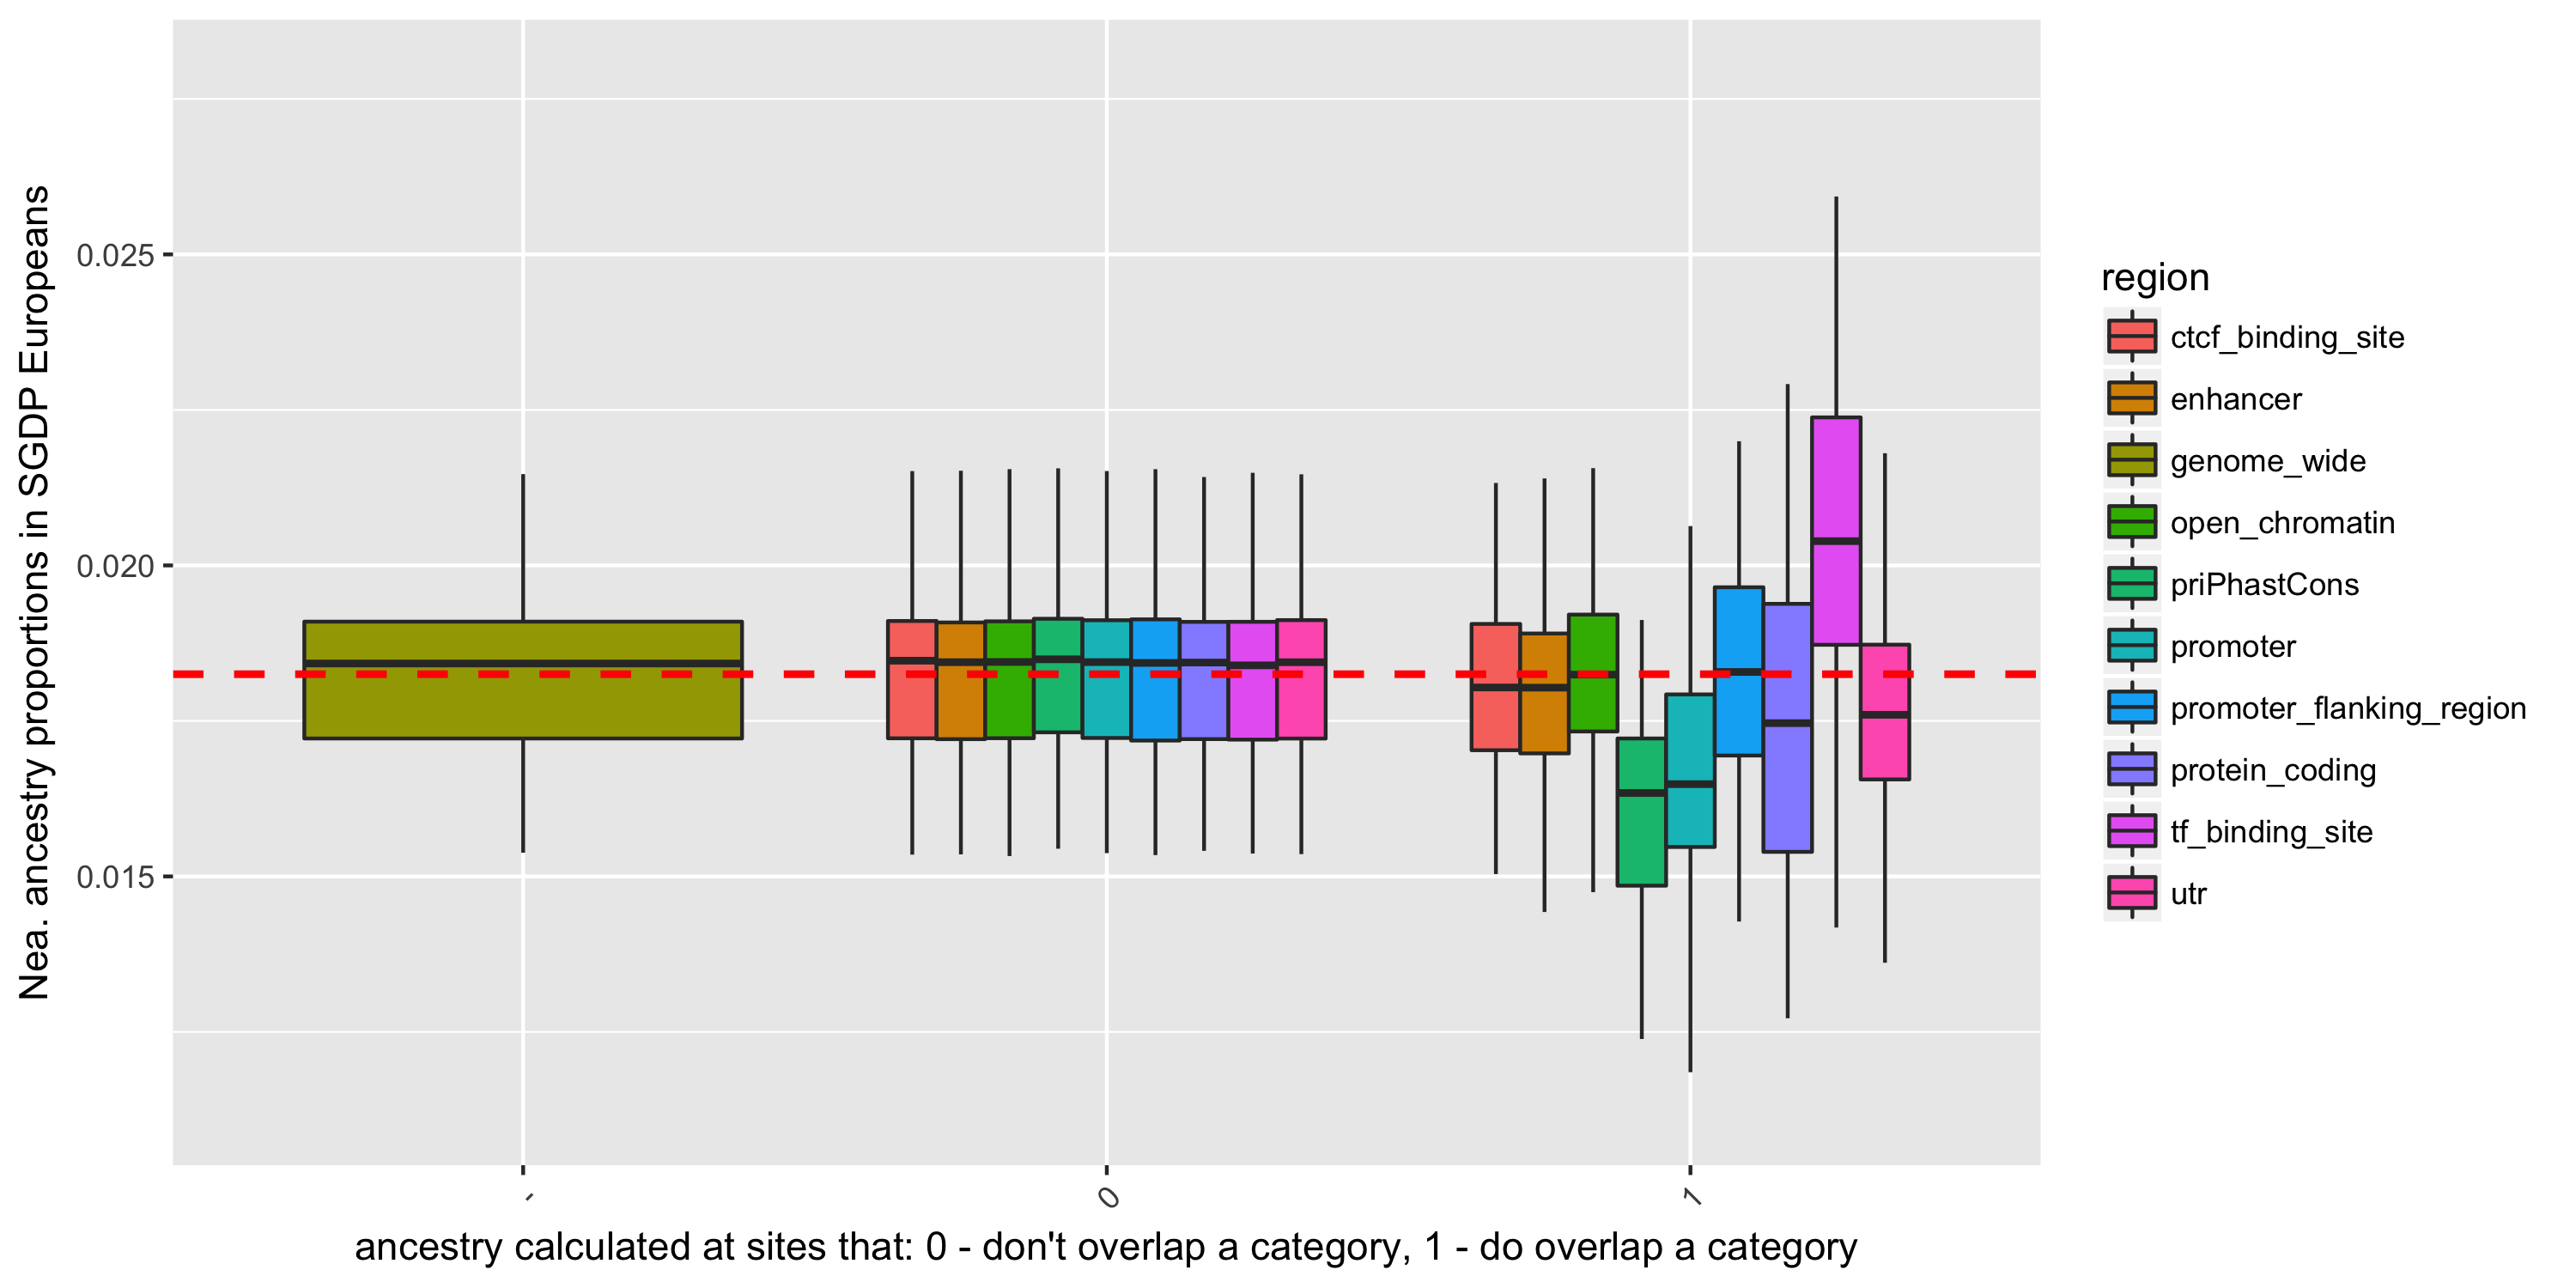

In [53]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(bind_rows(hits_nea, genome_wide) %>% filter(complete.cases(.)), aes(hits, nea, fill=region)) +
    geom_boxplot(outlier.size=NA) +
    geom_hline(yintercept=mean(genome_wide$nea), linetype=2, color="red", size=1) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(y="Nea. ancestry proportions in SGDP Europeans", x="ancestry calculated at sites that: 0 - don't overlap a category, 1 - do overlap a category")

In [ ]:
save(genotypes, regions, sites, tbl, hits_nea, genome_wide,
     file="../RData/introgression_predictors.RData")

In [54]:
dplyr::select(tbl, contains("hits_")) %>%
    gather(region, hit) %>%
    group_by(region, hit) %>%
    tally

region,hit,n
hits_ctcf_binding_site,0,475349
hits_ctcf_binding_site,1,8515
hits_enhancer,0,479844
hits_enhancer,1,4020
hits_open_chromatin,0,472708
hits_open_chromatin,1,11156
hits_priPhastCons,0,466423
hits_priPhastCons,1,17441
hits_promoter,0,478675
hits_promoter,1,5189


In [57]:
library(tidyverse)
library(stringr)
library(magrittr)

#setwd("/mnt/expressions/mp/slim-neanderthal/")
setwd("../")

#source("R/utils.R")

# load information about the Ice Age samples
emhs <- read_delim("clean_data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(name=str_replace(name, "-", "_"))

# load all genotypes of all SGDP, Ice Age and archaic samples
genotypes <- load_dataset("clean_data/ice_age.tsv",
                          "clean_data/sgdp.tsv",
                          "clean_data/archaics.tsv",
                          filter_damage=TRUE,
                          random_sample=TRUE) %>%
    select(one_of(emhs$name))

# calculate N% for each sample and join with the table of ages
nea_estimates <- summarise_all(genotypes, function(i) {mean(i, na.rm=TRUE) / 2}) %>%
    gather(name, nea) %>%
    inner_join(emhs)

Parsed with column specification:
cols(
  name = col_character(),
  age = col_integer()
)
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),
  Vindija = col_integer(),
  Denisovan = col_integer()
)
Joining, by = c("chrom", "pos", "ref", "alt")
Joining, by = c("chrom", "pos", "ref", "alt")
Warning message:
“Unknown variables: `Paglicci133`, `Cioclovina1`, `KremsWA3`, `Vestonice14`, `GoyetQ53_1`, `Paglicci108`, `GoyetQ376_19`, `GoyetQ56_16`, `Rigney1`, `HohleFels49`, `GoyetQ_2`, `Brillenhohle`, `HohleFels79`, `Burkhardtshohle`, `Rochedane`, `Iboussieres3

In [58]:
nea_estimates

name,nea,age
UstIshim,0.02797917,45020
Oase1,0.05881378,39610
Kostenki14,0.02656486,37470
GoyetQ116_1,0.02880845,34795
Muierii2,0.02226141,33300
Kostenki12,0.01810791,32415
Vestonice13,0.02894517,30870
Vestonice15,0.02538071,30870
Pavlov1,0.02412731,30260
Vestonice43,0.02375782,30010
